# CerealTimeKillersNet: Deep neural network for emotional states predictions from EEG data.

## Setup

In [1]:
# Packages & self-implemented functions
from CTKNetFunctions import *


## Model settings - Change models here!

In [15]:
class CTK_RNN_Net(nn.Module):
    def __init__(self, input_shape, out_size):

        super(CTK_RNN_Net, self).__init__()
        
        # Model hyperparametres (layer by layer)
        conv_channel = [5, 5]
        conv_kernel = [(3, 3), (3, 3)]
        pool_kernel = [(1, 1), (1, 1)]
        rnn_layer = [1]
        rnn_unit = [64]
        rnn_drop = [0]
        fc_unit = []
        drop_out = []
        
        self.rnn_layer = rnn_layer
        self.rnn_unit = rnn_unit
        
        # Hidden layers
        img_size = np.array(input_shape[2:])
        
        fc_input_size = np.int(np.prod(img_size) * input_shape[1])
        
        self.rnn1 = nn.LSTM(input_size = fc_input_size, hidden_size = rnn_unit[0], num_layers = rnn_layer[0], dropout = rnn_drop[0], batch_first = True)
        
        self.fc1 = nn.Linear(in_features = rnn_unit[0] * rnn_layer[0], out_features = out_size[0])
        

    def forward(self, x):
        
        shape = x.shape
        x = x.view(shape[0] * shape[1], shape[2], shape[3], shape[4])
        
        hidden = (torch.randn(self.rnn_layer[0], shape[0], self.rnn_unit[0]), 
                  torch.randn(self.rnn_layer[0], shape[0], self.rnn_unit[0]))   # for LSTM
        # hidden = torch.randn(self.rnn_layer[0], shape[0], self.rnn_unit[0])   # for simple RNN and GRU
        
        x = torch.flatten(x, 1)        
        x = x.view(shape[0], shape[1], -1)
        _, x = self.rnn1(x, hidden) # use final hidden state for non-series label prediction!
        x = x[0].permute(1, 0, 2) # for LSTM
        # x = x.permute(1, 0, 2) # for simple RNN and GRU
        x = F.relu(x)
        x = x.contiguous().view(x.shape[0], -1)
        
        x = self.fc1(x)
        x = F.sigmoid(x)
        
        return x

In [17]:
# Model selection function
def CerealTimeKillersModelGenerator(args, size):
    
    model = CTK_RNN_Net(input_shape = size[0], out_size = size[1])
    optimizer = optim.SGD(model.parameters(), lr = args['lr'], momentum = args['momentum'])
    criterion = nn.MSELoss()
    
    return model, optimizer, criterion


In [14]:
# Main function of model simulation
def CerealTimeKillersModelSimulator(args, label,
                                    TrainDataLoader, ValDataLoader, TestDataLoader, DataSize,
                                    is_2D = False,
                                    K_fold_train = False, k_folds = 1):
    
    N_FOLD = k_folds if K_fold_train else 1
    loss, acc, param, models = [], [], [], []
    
    for fold in range(N_FOLD):
        print('\n%d/%d Fold' % (fold + 1, N_FOLD))
        print('----------------------------')
    
        model, optimizer, criterion = CerealTimeKillersModelGenerator(args, size = DataSize)
        loss_list, acc_list, param_norm_list, trained_model, epoch = simulation(args, label, model,
                                                                                TrainDataLoader[fold],
                                                                                ValDataLoader[fold],
                                                                                TestDataLoader,
                                                                                is_2D = is_2D,
                                                                                optimizer = optimizer,
                                                                                criterion = criterion)
    
        loss_list, acc_list = np.array(loss_list), np.array(acc_list)
        loss.append([loss_list[0, epoch], loss_list[1, epoch], loss_list[2, epoch]])
        acc.append([acc_list[0, epoch], acc_list[1, epoch], acc_list[2, epoch]])
        param.append(param_norm_list[epoch])
        models.append(trained_model)
        
        print('Train/Val/Test Final MSE:', list(loss[-1]))
        print('Train/Val/Test Maximum Accuracy:', list(acc[-1]))
    
    return loss, acc, param, models



## Input settings - Change hypermatres here!

In [18]:
class CerealTimeKillersLabels:
    """
    Select labels for model prediction
    Labels used for prediction: info + electrode --> prediction
    CHANGE these with necessity before loading data
    """
    
    # ['subject', 'game', 'gender', 'age', 'disturbance', 'experience', 'memory']
    info = []
        
    # ['AF3', 'AF4', 'F3', 'F4', 'F7', 'F8', 'FC5', 'FC6', 'O1', 'O2', 'P7', 'P8', 'T7', 'T8']
    electrode = ['AF3', 'AF4', 'F3', 'F4', 'F7', 'F8', 'FC5', 'FC6', 'O1', 'O2', 'P7', 'P8', 'T7', 'T8']
        
    # ['satisfied', 'boring', 'horrible', 'calm', 'funny', 'valence', 'arousal']
    prediction = ['boring', 'horrible', 'calm', 'funny']
    # prediction = ['valence', 'arousal']
    
    # Quadrant emotions (applied after predicting valence/arousal)
    quadrant = ['boring', 'horrible', 'calm', 'funny']
    
    # Fixed variables
    fixed = info + prediction
    
    # Summarise labels for model
    label = info + electrode + prediction


In [19]:
# General settings
workspace_dir = '' # Workspace directionary
LabelRange = [1, 10] # The [min, max] of emotional states for transformation

# Whether to allow between-window dataset mixture
# SET TO FALSE FOR 4-DIMENSIONAL INPUT WHEN USING RNN
Is_between_subject = False # Default is True for 3-dimensional input

# Whether to transform 2D emotion  (valence/arousal) to 4 quardrant emotions ()
Is_2D_to_quardrant_emotion = False # Default is False

# Which to be based for allocating testing dataset (only when Is_between_subject = True)
Allocation_test = None # [None, 'subject', 'game'] # Default is None
test_ratio = 0.2 # Proportion of data used for testing when Allocation_test == None
Target_test = [25, 26, 27] # Int list for allocating corresponding game/subject as testing dataset when Allocation_test != None

# Model structural settings
N_inputtime = 1 # Time window for input sampling (Default is None for the whole timepoints)
N_stridetime = 1 # Temporal leap for input sampling when N_inputtime != None
N_perseg = 256 # N per seg of spectrogram
N_framerate = 128 # Framerate of spectrogram

# Model training settings
batch_size_train = 16 # Number of examples per minibatch during training
batch_size_test = 1 # Number of examples per minibatch during validation/testing
k_folds = 5 # Number for K-folds for training vs validation (validation is 1/k_folds of the train/val set)
K_fold_train = True # Whether enable the full K-fold cross-validation for training (if False, validate only once)

# Model hypermparametres
args = {
    'epochs': 300,
    'lr': 3e-3,
    'momentum': 0.99,
    'l1': 1e-3,
    'l2': 1e-3,
    'patience': 50,
    'device': set_device(),
}
print('Current device:', args['device'])

# Set random seed for reproducibility
SEED = 2021
set_seed(seed = SEED)
g_seed = torch.Generator()
g_seed.manual_seed(SEED)

# Torch-based data transformation
data_transform = None


Current device: cpu
Random seed 2021 has been set.


## MAIN CODE

In [20]:
# Implement Dataloader
FullDataset, DataSize, ExpIndex = CerealTimeKillersDataLoader(dir_base = workspace_dir,
                                                              label_class = CerealTimeKillersLabels,
                                                              label_range = LabelRange,
                                                              dataset_mix = Is_between_subject,
                                                              winlen = N_inputtime,
                                                              stride = N_stridetime,
                                                              nperseg = N_perseg,
                                                              fs = N_framerate,
                                                              transform = data_transform)

# Implement DataSplitter
SplittedDataset, SplittedDataLength = CerealTimeKillersDataSplitter(FullDataset, 
                                                                    exp_index = ExpIndex, 
                                                                    allocation_test = Allocation_test,
                                                                    test_ratio = test_ratio,
                                                                    target_test = Target_test,
                                                                    k_folds = k_folds,
                                                                    batch_size_train = batch_size_train,
                                                                    batch_size_test = batch_size_test,
                                                                    seed = SEED,
                                                                    generator = g_seed)

# Load Splited data
(TrainDataLoader, ValDataLoader, TestDataLoader) = (SplittedDataset['train'],
                                                    SplittedDataset['val'],
                                                    SplittedDataset['test'])

# Show data size
print('Dataset length:', SplittedDataLength)
print('Input shape: [channel, frequency, time]')
print('Single input data size:', DataSize[0])
print('Single output data size:', DataSize[1])


Dataset length: {'train': 70, 'val': 17, 'test': 21}
Input shape: [channel, frequency, time]
Single input data size: (169, 14, 129, 1)
Single output data size: (4,)


In [21]:
# Model selection
model, optimizer, criterion = CerealTimeKillersModelGenerator(args, size = DataSize)
print(model)
# summary(model, DataSize[0])


CTK_RNN_Net(
  (rnn1): LSTM(1806, 64, batch_first=True)
  (fc1): Linear(in_features=64, out_features=4, bias=True)
)



1/5 Fold
----------------------------


/Users/chronowanderer/.local/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


-----Epoch  10 / 300
Train/Val/TEST MSE: 0.11485100090503693 0.10769934165808889 0.11757787148512545
Train/Val/TEST Accuracy: 39.130434782608695 50.0 19.047619047619047
-----Epoch  20 / 300
Train/Val/TEST MSE: 0.0965364396572113 0.08925805716878837 0.10699379452992053
Train/Val/TEST Accuracy: 52.17391304347826 50.0 23.80952380952381
-----Epoch  30 / 300
Train/Val/TEST MSE: 0.08651121705770493 0.0833498046009077 0.10456071922644264
Train/Val/TEST Accuracy: 53.6231884057971 38.888888888888886 23.80952380952381
-----Epoch  40 / 300
Train/Val/TEST MSE: 0.08188522309064865 0.08399879911707507 0.09954096268241604
Train/Val/TEST Accuracy: 60.869565217391305 44.44444444444444 28.571428571428573
-----Epoch  50 / 300
Train/Val/TEST MSE: 0.07652852833271026 0.0779352347469992 0.09893404809935462
Train/Val/TEST Accuracy: 57.971014492753625 55.55555555555556 38.095238095238095
-----Epoch  60 / 300
Train/Val/TEST MSE: 0.061903683841228484 0.0787166975852516 0.09314471917847793
Train/Val/TEST Accurac

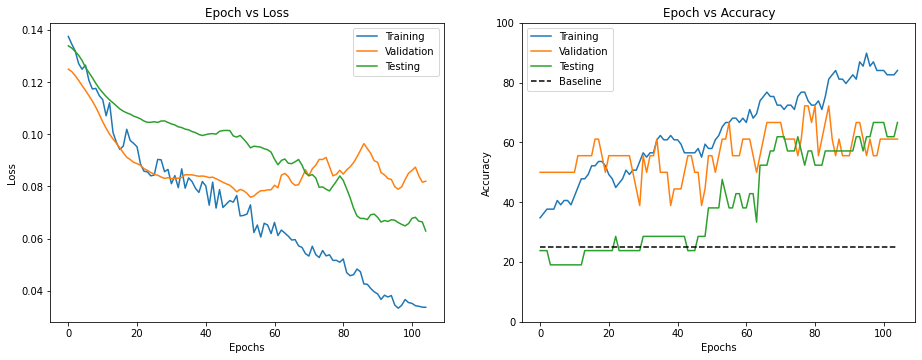

Train/Val/Test Final MSE: [0.07293367013335228, 0.07584431405282682, 0.0948038516743552]
Train/Val/Test Maximum Accuracy: [65.21739130434783, 61.111111111111114, 47.61904761904762]

2/5 Fold
----------------------------


-----Epoch  10 / 300
Train/Val/TEST MSE: 0.11623705625534057 0.108587679763635 0.12195467443338462
Train/Val/TEST Accuracy: 40.57971014492754 27.77777777777778 19.047619047619047
-----Epoch  20 / 300
Train/Val/TEST MSE: 0.09310484230518341 0.09219051028291385 0.10894433213841348
Train/Val/TEST Accuracy: 47.82608695652174 27.77777777777778 19.047619047619047
-----Epoch  30 / 300
Train/Val/TEST MSE: 0.08186998143792153 0.09165756983889474 0.10811566987207957
Train/Val/TEST Accuracy: 50.72463768115942 33.333333333333336 19.047619047619047
-----Epoch  40 / 300
Train/Val/TEST MSE: 0.07632665634155274 0.08909985516220331 0.10367756700586706
Train/Val/TEST Accuracy: 53.6231884057971 33.333333333333336 23.80952380952381
-----Epoch  50 / 300
Train/Val/TEST MSE: 0.07358253896236419 0.08541040391557747 0.10255276637950114
Train/Val/TEST Accuracy: 53.6231884057971 38.888888888888886 28.571428571428573
-----Epoch  60 / 300
Train/Val/TEST MSE: 0.0705492690205574 0.08662681048735976 0.099255347136585

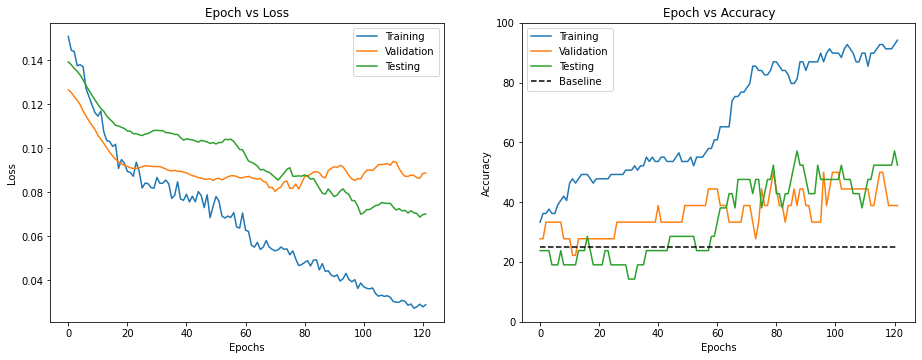

Train/Val/Test Final MSE: [0.05336311459541321, 0.08038958255201578, 0.08671235180060778]
Train/Val/Test Maximum Accuracy: [78.26086956521739, 38.888888888888886, 47.61904761904762]

3/5 Fold
----------------------------


-----Epoch  10 / 300
Train/Val/TEST MSE: 0.11219204366207122 0.12376127501620966 0.11825196116807915
Train/Val/TEST Accuracy: 48.57142857142857 52.94117647058823 28.571428571428573
-----Epoch  20 / 300
Train/Val/TEST MSE: 0.09174235165119171 0.10989645737058976 0.11154700753589471
Train/Val/TEST Accuracy: 47.142857142857146 41.1764705882353 28.571428571428573
-----Epoch  30 / 300
Train/Val/TEST MSE: 0.08135582357645035 0.11002694990705042 0.11587642771857125
Train/Val/TEST Accuracy: 52.857142857142854 41.1764705882353 28.571428571428573
-----Epoch  40 / 300
Train/Val/TEST MSE: 0.0757444828748703 0.10572867106427164 0.11631425008887336
Train/Val/TEST Accuracy: 51.42857142857143 58.8235294117647 33.333333333333336
-----Epoch  50 / 300
Train/Val/TEST MSE: 0.06805421262979508 0.10445128414122497 0.10905033691475789
Train/Val/TEST Accuracy: 54.285714285714285 52.94117647058823 33.333333333333336
-----Epoch  60 / 300
Train/Val/TEST MSE: 0.06075699552893639 0.10257361160919946 0.1096126088606

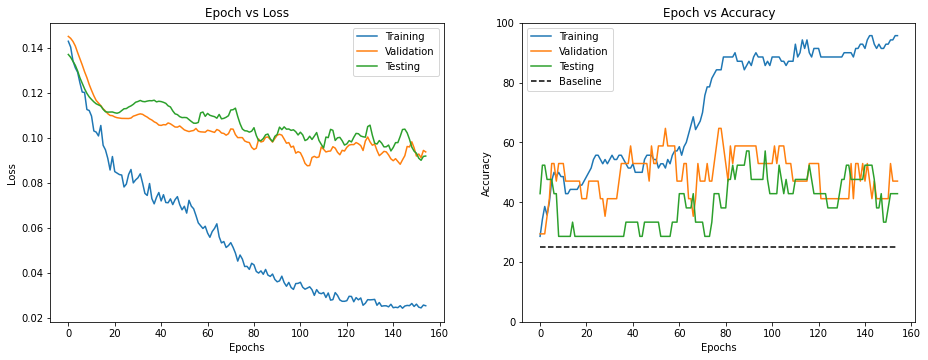

Train/Val/Test Final MSE: [0.03327348493039608, 0.08763083711485653, 0.09935113226640083]
Train/Val/Test Maximum Accuracy: [88.57142857142857, 58.8235294117647, 52.38095238095238]

4/5 Fold
----------------------------


-----Epoch  10 / 300
Train/Val/TEST MSE: 0.11193408817052841 0.1161584025796722 0.11882317962036246
Train/Val/TEST Accuracy: 47.142857142857146 29.41176470588235 38.095238095238095
-----Epoch  20 / 300
Train/Val/TEST MSE: 0.08828811794519424 0.10362816864953321 0.11026133787596509
Train/Val/TEST Accuracy: 48.57142857142857 23.529411764705884 33.333333333333336
-----Epoch  30 / 300
Train/Val/TEST MSE: 0.08295780271291733 0.10240331007277265 0.11409539551961989
Train/Val/TEST Accuracy: 51.42857142857143 35.294117647058826 23.80952380952381
-----Epoch  40 / 300
Train/Val/TEST MSE: 0.07725799530744552 0.10113937002332772 0.11177335781533093
Train/Val/TEST Accuracy: 51.42857142857143 35.294117647058826 23.80952380952381
-----Epoch  50 / 300
Train/Val/TEST MSE: 0.06888241469860076 0.1022067970924956 0.11302859143220953
Train/Val/TEST Accuracy: 55.714285714285715 41.1764705882353 23.80952380952381
-----Epoch  60 / 300
Train/Val/TEST MSE: 0.05899282619357109 0.10205418276874458 0.1081042790430

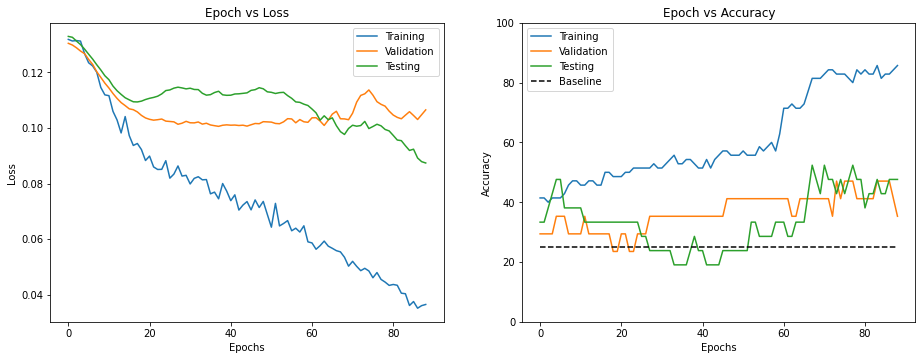

Train/Val/Test Final MSE: [0.07450352683663368, 0.1005983549882384, 0.11323708291387274]
Train/Val/Test Maximum Accuracy: [54.285714285714285, 35.294117647058826, 23.80952380952381]

5/5 Fold
----------------------------


-----Epoch  10 / 300
Train/Val/TEST MSE: 0.11094186604022979 0.1300473046653411 0.12148465801562582
Train/Val/TEST Accuracy: 42.857142857142854 47.05882352941177 28.571428571428573
-----Epoch  20 / 300
Train/Val/TEST MSE: 0.08665185272693635 0.11259339705986135 0.10659922827922162
Train/Val/TEST Accuracy: 51.42857142857143 41.1764705882353 28.571428571428573
-----Epoch  30 / 300
Train/Val/TEST MSE: 0.07908638268709182 0.10861125084407189 0.10713109799793788
Train/Val/TEST Accuracy: 55.714285714285715 47.05882352941177 33.333333333333336
-----Epoch  40 / 300
Train/Val/TEST MSE: 0.07274490892887116 0.11006245959331007 0.11014799090723197
Train/Val/TEST Accuracy: 52.857142857142854 58.8235294117647 33.333333333333336
-----Epoch  50 / 300
Train/Val/TEST MSE: 0.06187834888696671 0.10771250396090395 0.10665589473432019
Train/Val/TEST Accuracy: 64.28571428571429 52.94117647058823 14.285714285714286
-----Epoch  60 / 300
Train/Val/TEST MSE: 0.05291577205061913 0.10806657505386016 0.097920323500

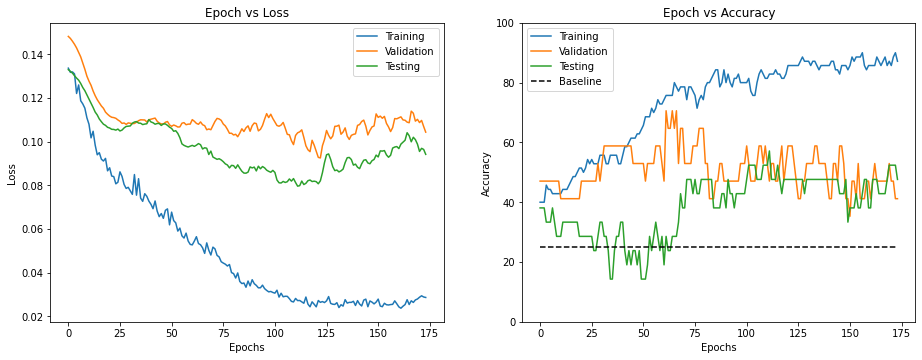

Train/Val/Test Final MSE: [0.026339871063828468, 0.09255738512558095, 0.08206847188107315]
Train/Val/Test Maximum Accuracy: [85.71428571428571, 58.8235294117647, 47.61904761904762]


In [22]:
# Model simulation
loss_K, acc_K, param_K, models_K = CerealTimeKillersModelSimulator(args, CerealTimeKillersLabels, 
                                                                   TrainDataLoader,
                                                                   ValDataLoader,
                                                                   TestDataLoader,
                                                                   DataSize,
                                                                   is_2D = Is_2D_to_quardrant_emotion,
                                                                   K_fold_train = K_fold_train,
                                                                   k_folds = k_folds)



In [23]:
# Average results from K-folds
print('Train/Val/Test Average MSE:', list(np.mean(np.array(loss_K), axis = 0)))
print('Train/Val/Test Average Accuracy:', list(np.mean(np.array(acc_K), axis = 0)))


Train/Val/Test Average MSE: [0.05208273351192474, 0.0874040947667037, 0.09523457810726194]
Train/Val/Test Average Accuracy: [74.40993788819875, 50.588235294117645, 43.80952380952381]


## Single prediction results

In [24]:
# Print single prediction results from data loader
fold = 0
ShowDataset = TestDataLoader
ShowModel = models_K[fold]
BATCH_SHOW = 20

ShowModel.eval()

with torch.no_grad():
    for idx, (data, target, quadrant) in enumerate(ShowDataset):
        data = data.type(torch.float).to(args['device'])
        target = target.type(torch.float).to(args['device'])
        quadrant = quadrant.type(torch.float).to(args['device'])
        output = ShowModel(data)
            
        eval_loss = criterion(output, target).item()
        
        if not Is_2D_to_quardrant_emotion:
            predicted = maximum_extraction(output)
            labels = maximum_extraction(target)
        else:
            predicted = emotion_transformation(output, CerealTimeKillersLabels)
            flabels = maximum_extraction(quadrant)
            labels = emotion_transformation(target, CerealTimeKillersLabels)
        
        eval_acc = maximum_comparison(predicted, labels) * 100.0 / target.size(0)
        
        if idx < BATCH_SHOW:
            print('Batch', idx + 1, ' ( Size', target.size(0), '):')
            print('Output Example:', output[0].detach().numpy(), 'with label ', predicted[0])
            if not Is_2D_to_quardrant_emotion:
                print('Target Example:', target[0].detach().numpy(), 'with label ', labels[0])
            else:
                print('Target Example:', target[0].detach().numpy(), 'with label ', flabels[0])
                print('Real Label Example:', quadrant[0].detach().numpy(), 'with label ', labels[0])
            print('------- MSE:', eval_loss, ' Accuracy:', eval_acc, '%-------\n')
        else:
            print('Etc. for totally ', len(ShowDataset), 'batches.')
            break
 

Batch 1  ( Size 1 ):
Output Example: [0.22856772 0.2797896  0.31893644 0.42188042] with label  [3]
Target Example: [0.         1.         0.11111111 0.        ] with label  [1]
------- MSE: 0.19803017377853394  Accuracy: 0.0 %-------

Batch 2  ( Size 1 ):
Output Example: [0.3674884  0.19898729 0.38977948 0.36962157] with label  [2]
Target Example: [1. 0. 1. 0.] with label  [0, 2]
------- MSE: 0.23716402053833008  Accuracy: 100.0 %-------

Batch 3  ( Size 1 ):
Output Example: [0.25863418 0.1428256  0.5451968  0.46493116] with label  [2]
Target Example: [0.7777778  0.         0.22222222 0.        ] with label  [0]
------- MSE: 0.15259569883346558  Accuracy: 0.0 %-------

Batch 4  ( Size 1 ):
Output Example: [0.22136106 0.15612751 0.4199618  0.4211076 ] with label  [3]
Target Example: [0.         0.         0.44444445 0.7777778 ] with label  [3]
------- MSE: 0.050297386944293976  Accuracy: 100.0 %-------

Batch 5  ( Size 1 ):
Output Example: [0.21759865 0.23147984 0.43903655 0.4232856 ] w